# 信用情報の学習

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")

## 【問題1】コンペティション内容の確認

#### **何を学習し、何を予測するのか**
顧客データを読み込み、個人の返済能力の有無を予測する

#### **どのようなファイルを作りKaggleに提出するか**
各IDに対してTARGET変数の（返済能力が無いと判断される）確率

以下フォーマットのファイルを提出する

SK_ID_CURR,TARGET

100001,0.1

100005,0.9

100013,0.2

etc.

#### **提出されたものはどういった指標値で評価されるのか**
AUC(Area under an ROC curve)

[【ROC曲線とAUC】機械学習の評価指標についての基礎講座](https://www.randpy.tokyo/entry/roc_auc)

In [5]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
train.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [4]:
X=train.iloc[:,2:]
y=train.iloc[:,1]
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 【問題2】学習と検証

In [5]:
#補間・置換(train)
null_sum = 0
for col in train.columns:
    #欠損の補間（暫定版）
    null_sum = train[col].isnull().sum()
    train_length = train[col].count()
    if null_sum > 0:
        if train[col].dtype == object:
            train[col] = train[col].fillna(train[col].mode()[0]) #object型は最頻値
        else:
            train[col] = train[col].fillna(train[col].mean())  #数値は平均値
    

In [6]:
X=train.iloc[:,2:]
y=train.iloc[:,1]

In [7]:
#object型を抽出
categorical_features=[]
for col in train.columns:
    if train[col].dtype=="object":
        categorical_features.append(col)

In [8]:
categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [9]:
#one-hot　encoding
X_oh=pd.get_dummies(X, columns=categorical_features)

In [10]:
X_oh.shape

(307511, 244)

In [11]:
y.shape

(307511,)

In [12]:
X_train, X_valid, y_train, y_valid=train_test_split(X_oh, y, test_size=0.25, random_state=0)

ランダムフォレストで学習

In [18]:
Rf=RandomForestRegressor()
Rf.fit(X_train, y_train)
y_pred=Rf.predict(X_valid)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
#推定
y_pred

array([0.4, 0. , 0.1, ..., 0.2, 0.2, 0.1])

In [20]:
#valid data で評価

roc=roc_auc_score(y_valid, y_pred)
roc

0.6411023439855781

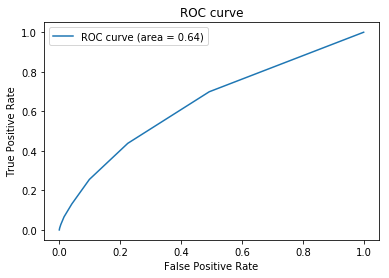

In [30]:
#ROC曲線とAUCによる評価
fp, tp, thresholds = metrics.roc_curve(y_valid, y_pred)
auc = metrics.auc(fp, tp)

plt.plot(fp, tp, label='ROC curve (area = {:.2f})'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 【問題3】テストデータに対する推定

In [31]:
#test data の前処理
null_sum = 0
for col in test.columns:
    #欠損の補間
    null_sum = test[col].isnull().sum()
    test_length = test[col].count()
    if null_sum > 0:
        if test[col].dtype == object:
            test[col] = test[col].fillna(test[col].mode()[0])
        else:
            test[col] = test[col].fillna(test[col].mean())
test_oh=pd.get_dummies(test.iloc[:,1:], columns=categorical_features)

In [32]:
#trainデータにあって、testデータにない列を追加
def fill_missing_columns(df_a, df_b):
    columns_for_b = set(df_a.columns) - set(df_b.columns)
    for column in columns_for_b:
        df_b[column] = 0
        
fill_missing_columns(X_oh, test_oh)

In [33]:
X_oh.shape

(307511, 244)

In [34]:
test_oh.shape

(48744, 244)

In [35]:
#全てのtrainデータで学習
Rf=RandomForestRegressor()
Rf.fit(X_oh, y)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [36]:
y_test=Rf.predict(test_oh)

In [37]:
y_test

array([0.1, 0.2, 0. , ..., 0.2, 0.2, 0.6])

kaggle提出

In [38]:
submission_csv = pd.read_csv("sample_submission.csv")

In [40]:
submission_csv.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [43]:
submission_csv["TARGET"]=y_test
submission_csv.head()

,SK_ID_CURR,TARGET
0,100001,0.1
1,100005,0.2
2,100013,0.0
3,100028,0.2
4,100038,0.2


In [42]:
submission_csv.to_csv("first_submission.csv", index=False)

Private Score:0.59875

Public Score:0.60403

## 【問題4】特徴量エンジニアリング

標準化する

In [13]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by 

In [14]:
Rf2=RandomForestRegressor()
Rf2.fit(X_train, y_train)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
y_pred=Rf2.predict(X_valid)

In [19]:
#valid data で評価
roc=metrics.roc_auc_score(y_valid, y_pred)
roc

0.6451513544567004

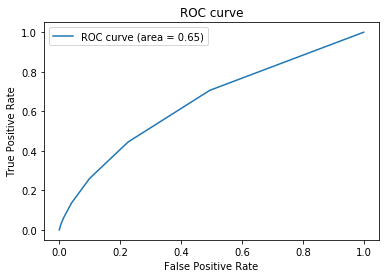

In [21]:
#ROC曲線とAUCによる評価
fp, tp, thresholds = metrics.roc_curve(y_valid, y_pred)
auc = metrics.auc(fp, tp)

plt.plot(fp, tp, label='ROC curve (area = {:.2f})'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ほとんど変わらないが正規化することで微妙に精度UPした

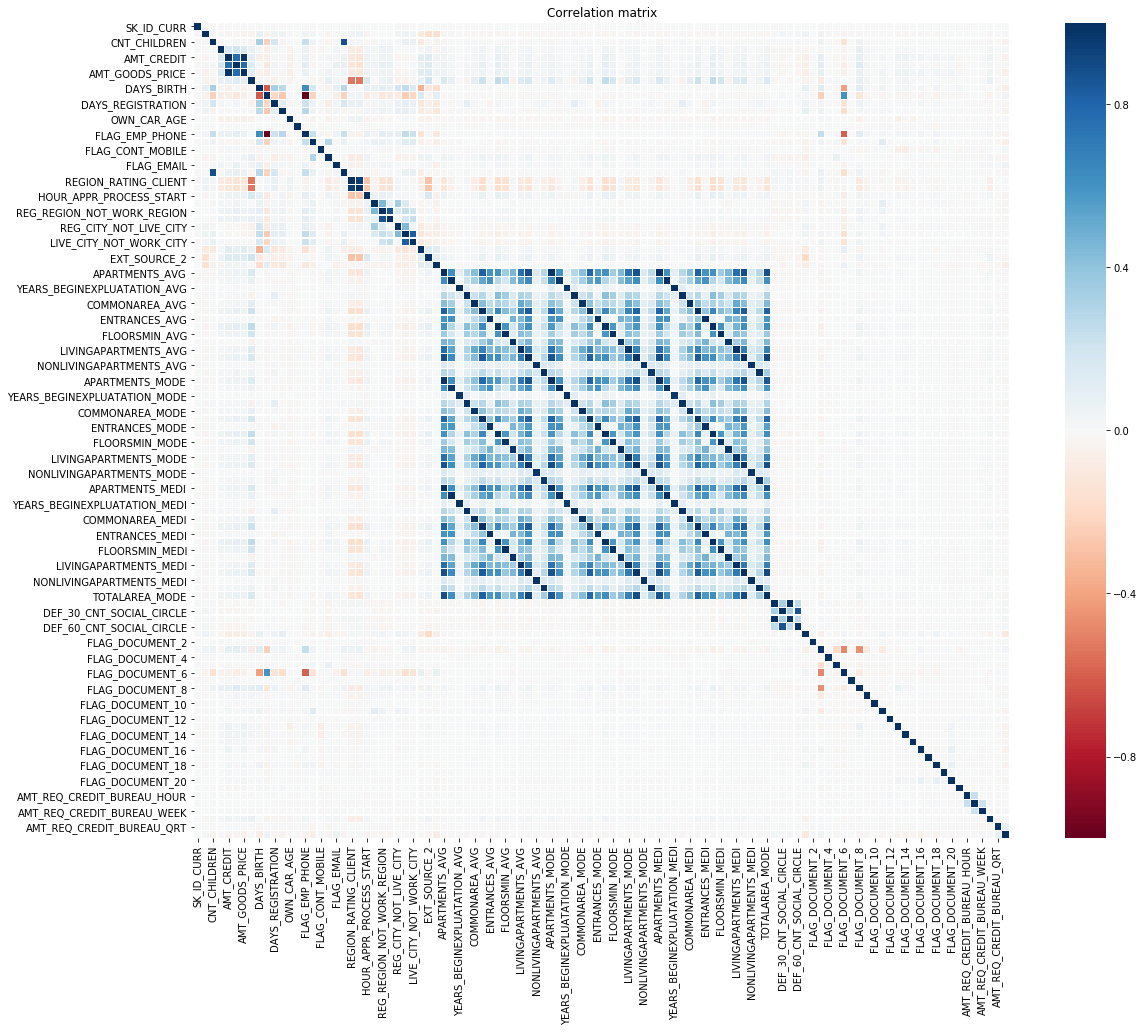

In [42]:
corrmat = train.corr()

colormap = plt.cm.RdBu
plt.subplots(figsize=(20, 15))
plt.title('Correlation matrix')
sns.heatmap(corrmat,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)
plt.show()

In [48]:
#ターゲットとの相関が高い特徴量を調べる
df=np.abs(corrmat["TARGET"])
df.sort_values(ascending = False).head(10)

TARGET                         1.000000
EXT_SOURCE_2                   0.160303
EXT_SOURCE_3                   0.157397
EXT_SOURCE_1                   0.099152
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64

In [35]:
corrmat["EXT_SOURCE_2"].sort_values(ascending=True)

REGION_RATING_CLIENT          -2.926098e-01
REGION_RATING_CLIENT_W_CITY   -2.880152e-01
DAYS_LAST_PHONE_CHANGE        -1.955688e-01
TARGET                        -1.603032e-01
DAYS_BIRTH                    -9.188484e-02
REG_CITY_NOT_WORK_CITY        -7.588664e-02
DAYS_REGISTRATION             -5.983566e-02
LIVE_CITY_NOT_WORK_CITY       -5.883531e-02
DAYS_ID_PUBLISH               -5.090137e-02
OWN_CAR_AGE                   -4.544785e-02
REG_CITY_NOT_LIVE_CITY        -4.322036e-02
DEF_60_CNT_SOCIAL_CIRCLE      -3.226678e-02
FLAG_DOCUMENT_3               -3.066692e-02
DEF_30_CNT_SOCIAL_CIRCLE      -3.032970e-02
DAYS_EMPLOYED                 -2.073939e-02
AMT_REQ_CREDIT_BUREAU_YEAR    -2.026532e-02
OBS_30_CNT_SOCIAL_CIRCLE      -1.919005e-02
OBS_60_CNT_SOCIAL_CIRCLE      -1.883371e-02
FLAG_WORK_PHONE               -1.882328e-02
FLAG_DOCUMENT_6               -1.867862e-02
CNT_CHILDREN                  -1.799642e-02
FLAG_DOCUMENT_21              -7.236180e-03
FLAG_DOCUMENT_11              -4

In [36]:
corrmat["EXT_SOURCE_3"].sort_values(ascending=True)

DAYS_BIRTH                    -0.181252
TARGET                        -0.157397
DAYS_ID_PUBLISH               -0.116270
FLAG_EMP_PHONE                -0.103150
DAYS_REGISTRATION             -0.096245
REG_CITY_NOT_WORK_CITY        -0.070807
REG_CITY_NOT_LIVE_CITY        -0.068811
AMT_REQ_CREDIT_BUREAU_YEAR    -0.068433
DAYS_LAST_PHONE_CHANGE        -0.067926
FLAG_WORK_PHONE               -0.056941
FLAG_EMAIL                    -0.047351
REG_REGION_NOT_WORK_REGION    -0.043210
REG_REGION_NOT_LIVE_REGION    -0.042574
LIVE_CITY_NOT_WORK_CITY       -0.039450
CNT_CHILDREN                  -0.038483
HOUR_APPR_PROCESS_START       -0.036009
DEF_30_CNT_SOCIAL_CIRCLE      -0.032514
DEF_60_CNT_SOCIAL_CIRCLE      -0.030530
AMT_INCOME_TOTAL              -0.029287
FLAG_DOCUMENT_3               -0.027377
LIVE_REGION_NOT_WORK_REGION   -0.026156
CNT_FAM_MEMBERS               -0.025059
AMT_REQ_CREDIT_BUREAU_WEEK    -0.020427
AMT_REQ_CREDIT_BUREAU_QRT     -0.018563
FLAG_DOCUMENT_18              -0.014811


In [37]:
corrmat["EXT_SOURCE_1"].sort_values(ascending=True)

DAYS_BIRTH                    -0.358525
FLAG_EMP_PHONE                -0.148872
REG_CITY_NOT_WORK_CITY        -0.126052
DAYS_REGISTRATION             -0.109593
REG_CITY_NOT_LIVE_CITY        -0.099524
TARGET                        -0.099152
CNT_CHILDREN                  -0.096844
DAYS_ID_PUBLISH               -0.088240
DAYS_LAST_PHONE_CHANGE        -0.088058
LIVE_CITY_NOT_WORK_CITY       -0.079980
REGION_RATING_CLIENT_W_CITY   -0.077912
REGION_RATING_CLIENT          -0.077904
CNT_FAM_MEMBERS               -0.066618
FLAG_WORK_PHONE               -0.052642
REG_REGION_NOT_WORK_REGION    -0.034823
FLAG_DOCUMENT_8               -0.034655
OWN_CAR_AGE                   -0.033529
FLAG_DOCUMENT_3               -0.028909
REG_REGION_NOT_LIVE_REGION    -0.023941
LIVE_REGION_NOT_WORK_REGION   -0.021786
DEF_60_CNT_SOCIAL_CIRCLE      -0.020044
DEF_30_CNT_SOCIAL_CIRCLE      -0.018968
FLAG_DOCUMENT_18              -0.018218
OBS_30_CNT_SOCIAL_CIRCLE      -0.017607
OBS_60_CNT_SOCIAL_CIRCLE      -0.017312


相関のありそうな特徴量だけに絞ってみる

In [55]:
corr_data = train.loc[: , ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3", "DAYS_BIRTH", "TARGET"]]
X_1 = corr_data.dropna(how = "any")
X_1.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,TARGET
0,0.083037,0.262949,0.139376,-9461,1
1,0.311267,0.622246,0.510853,-16765,0
2,0.502130,0.555912,0.729567,-19046,0
3,0.502130,0.650442,0.510853,-19005,0
4,0.502130,0.322738,0.510853,-19932,0


In [59]:
X_2=X_1.drop("TARGET",axis=1)
y_2=X_1.iloc[:,-1]

In [60]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_2,y_2,test_size = 0.25,random_state=0)

In [61]:
#標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [67]:
Rf3=RandomForestRegressor()
Rf3.fit(X_train, y_train)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:
y_pred=Rf3.predict(X_test)

In [69]:
#test data で評価
roc=metrics.roc_auc_score(y_valid, y_pred)
roc

0.4923049370951668

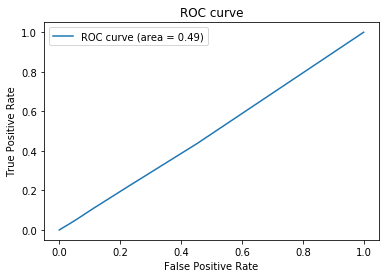

In [70]:
#ROC曲線とAUCによる評価
fp, tp, thresholds = metrics.roc_curve(y_valid, y_pred)
auc = metrics.auc(fp, tp)

plt.plot(fp, tp, label='ROC curve (area = {:.2f})'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [75]:
X_3=X_2.drop(["EXT_SOURCE_2","EXT_SOURCE_3"], axis=1)
X_3.head()

,EXT_SOURCE_1,DAYS_BIRTH
0,0.083037,-9461
1,0.311267,-16765
2,0.502130,-19046
3,0.502130,-19005
4,0.502130,-19932


In [76]:
X_train,X_test,y_train,y_test = train_test_split(X_3,y_2,test_size = 0.25,random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [77]:
Rf4=RandomForestRegressor()
Rf4.fit(X_train, y_train)

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [78]:
y_pred=Rf4.predict(X_test)
#test data で評価
roc=metrics.roc_auc_score(y_valid, y_pred)
roc

0.5014486570865129

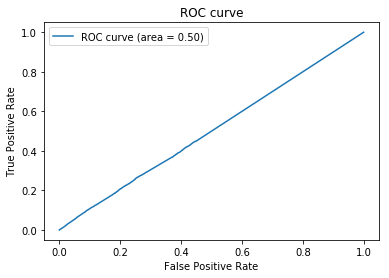

In [79]:
#ROC曲線とAUCによる評価
fp, tp, thresholds = metrics.roc_curve(y_valid, y_pred)
auc = metrics.auc(fp, tp)

plt.plot(fp, tp, label='ROC curve (area = {:.2f})'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [3]:
#object型の特徴量抽出
categorical_feats = [f for f in train.columns if train[f].dtype == 'object']

categorical_feats 
for f_ in categorical_feats:
    train[f_], _ = pd.factorize(train[f_])
    # Set feature type as categorical
    train[f_] = train[f_].astype('category')
    

In [4]:
#feature_importancesをみる
def get_feature_importances(data, shuffle, seed=None):
    # 特徴量のみを収集
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
   
    # 必要に応じターゲットをシャッフル
    y = data['TARGET'].copy()
    if shuffle:
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # LightGBM（RF mode）を選定。（sklearn RandomForestより早い）
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # 学習させる
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # feature importances取得
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [5]:
np.random.seed(123)
# actual importance
actual_imp_df = get_feature_importances(data=train, shuffle=False)

In [6]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,NAME_CONTRACT_TYPE,4819.676787,131,0.757462
1,CODE_GENDER,24090.765133,512,0.757462
2,FLAG_OWN_CAR,2666.568874,81,0.757462
3,FLAG_OWN_REALTY,696.747799,32,0.757462
4,CNT_CHILDREN,930.877024,40,0.757462


In [7]:
null_imp_df = pd.DataFrame()
nb_runs = 10
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)
null_imp_df.head()

Done with   10 of   10 (Spent   5.7 min)

,feature,importance_gain,importance_split,trn_score,run
0,NAME_CONTRACT_TYPE,178.969080,24,0.714683,1
1,CODE_GENDER,387.732955,74,0.714683,1
2,FLAG_OWN_CAR,237.031107,37,0.714683,1
3,FLAG_OWN_REALTY,430.885483,58,0.714683,1
4,CNT_CHILDREN,577.820721,60,0.714683,1


In [8]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

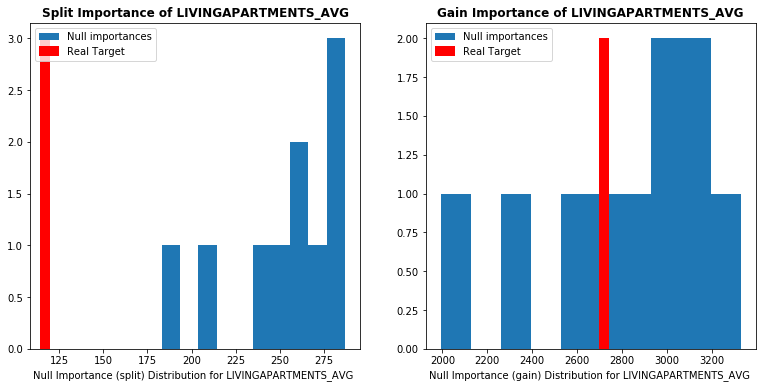

In [9]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

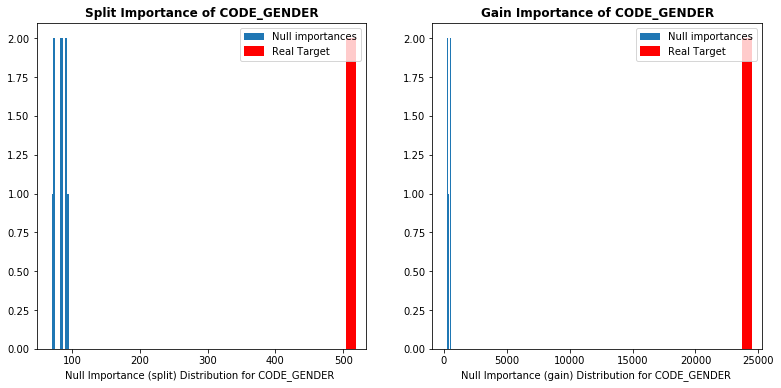

In [10]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

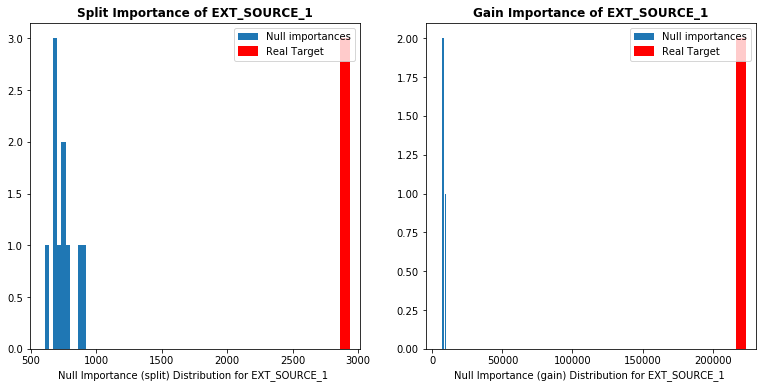

In [11]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_1')

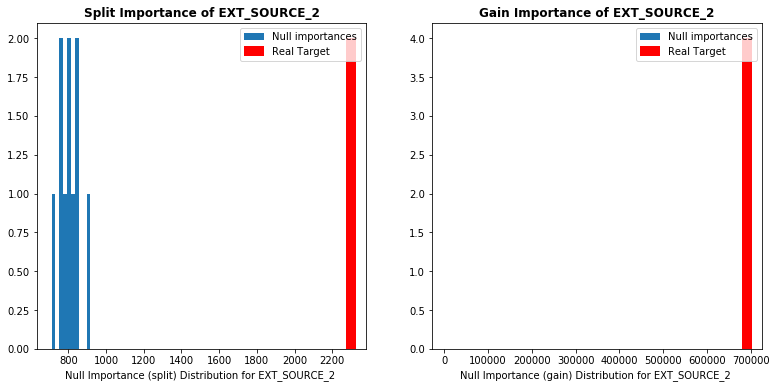

In [12]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_2')

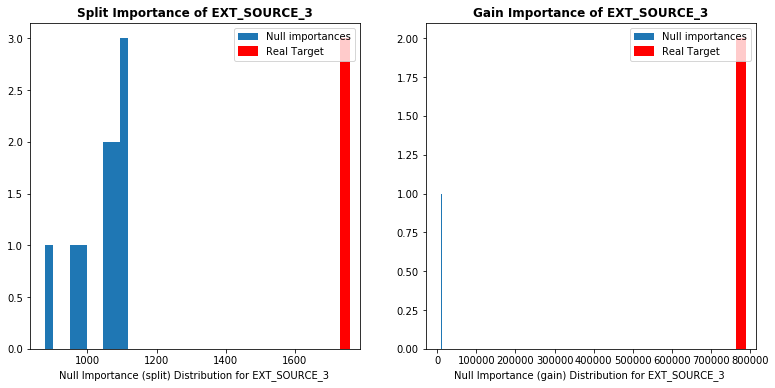

In [13]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_3')

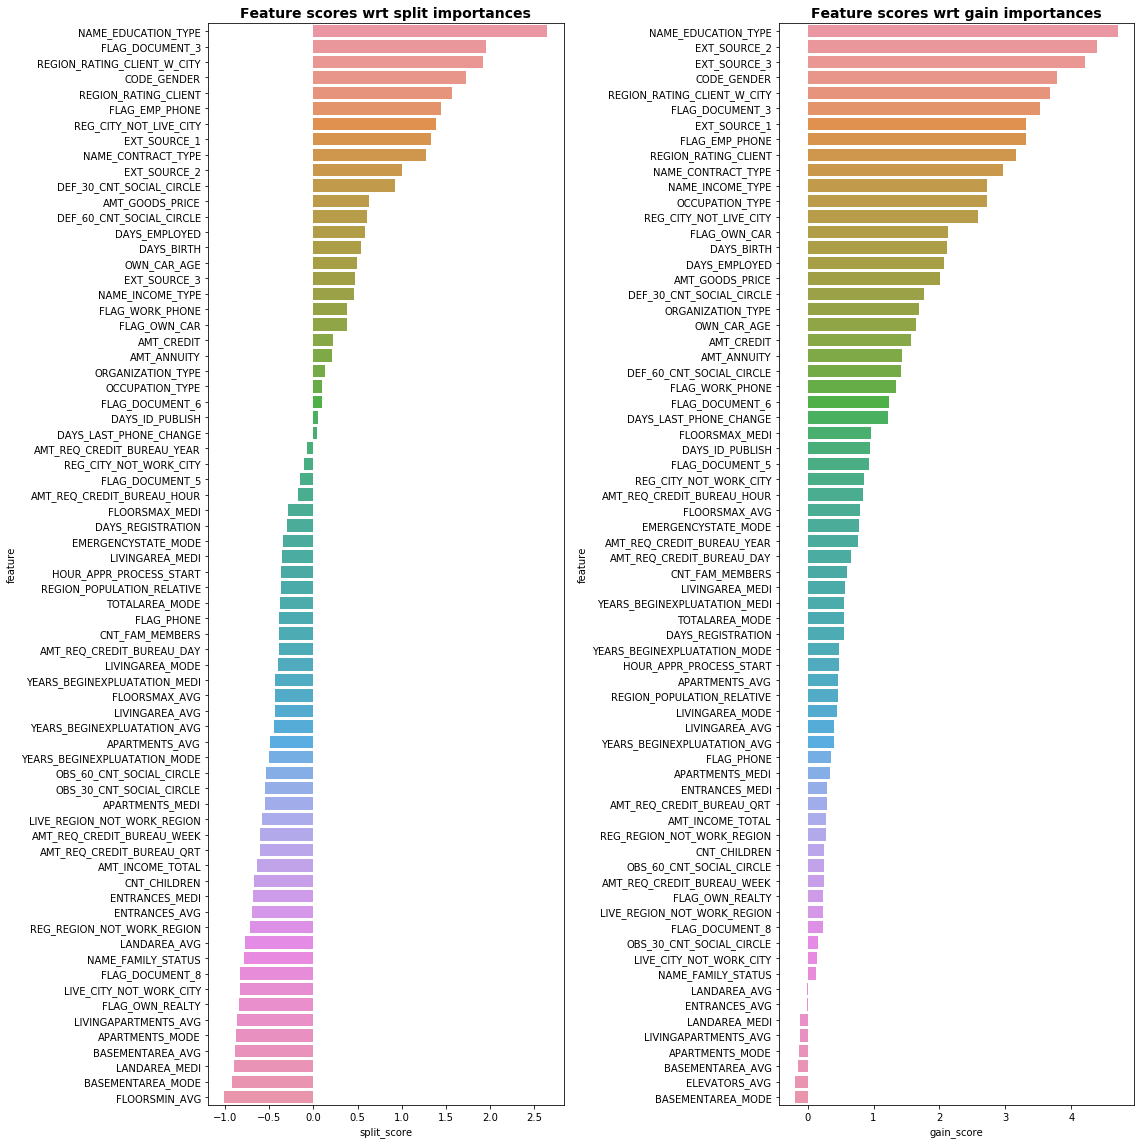

In [14]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

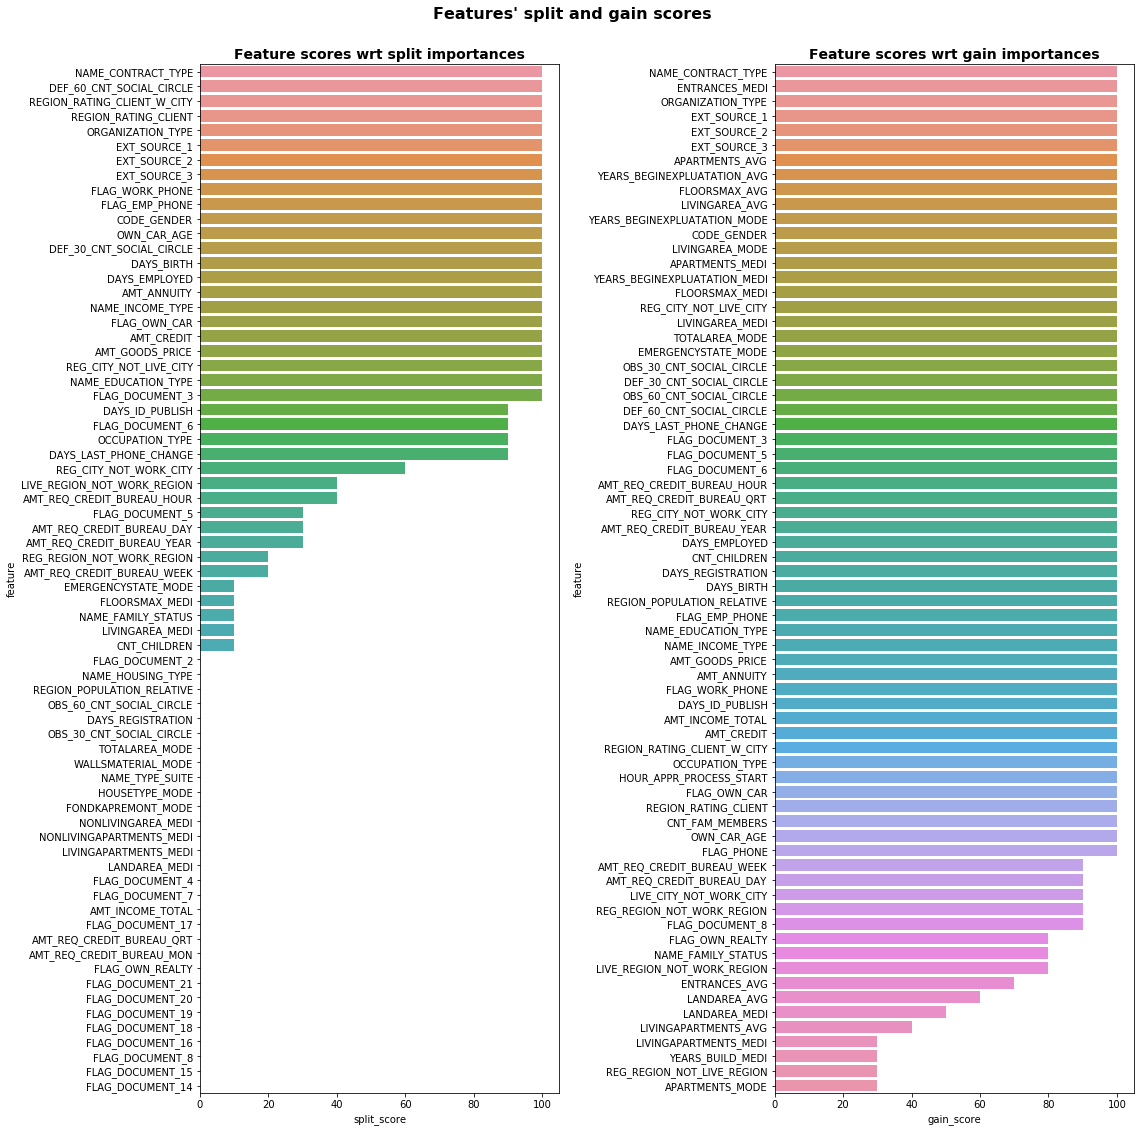

In [15]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)